In [94]:
import re
import xml.sax.saxutils as saxutils

from bs4 import BeautifulSoup

import tensorflow as tf
from keras.models import Sequential, load_model
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, LSTM, Dropout, Activation

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from sklearn.model_selection import train_test_split

from pandas import DataFrame

from random import random
import numpy as np
# Set Numpy random seed
np.random.seed(1)

In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# **The dataset path should be similar to the image below**



*  Add shortcut to the drive which is named as Gowtham_Batchala_Interos_Challenge and you will be able to see it in your MyDrive 
*   The path of the folder should be '/content/gdrive/MyDrive/Gowtham_Batchala_Interos_Challenge/'



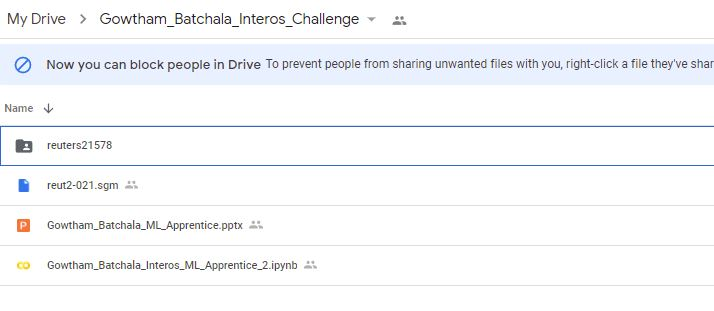

In [5]:
# data_folder path is your input_data in the google drive, for me it was as shown below
# It's better to create a folder in the Google drive

data_folder = '/content/gdrive/MyDrive/Gowtham_Batchala_Interos_Challenge/reuters21578/'

sgml_number_of_files = 21
sgml_file_name_template = 'reut2-{}.sgm'

# Category files
category_files = {
    'to_': ('Topics', 'all-topics-strings.lc.txt'),
    'pl_': ('Places', 'all-places-strings.lc.txt'),
    'pe_': ('People', 'all-people-strings.lc.txt'),
    'or_': ('Organizations', 'all-orgs-strings.lc.txt'),
    'ex_': ('Exchanges', 'all-exchanges-strings.lc.txt')
}

# **Preparing documents and categories**

In [6]:
# Read all categories
category_data = []

for category_prefix in category_files.keys():
    with open(data_folder + category_files[category_prefix][1], 'r') as file:
        for category in file.readlines():
            category_data.append([category_prefix + category.strip().lower(), 
                                  category_files[category_prefix][0], 
                                  0])

# Create category dataframe
news_categories = DataFrame(data=category_data, columns=['Name', 'Type', 'Newslines'])

In [7]:
len(news_categories)

672

In [93]:
def update_frequencies(categories):
    for category in categories:
        idx = news_categories[news_categories.Name == category].index[0]
        f = news_categories._get_value(idx, 'Newslines')
        news_categories._set_value(idx, 'Newslines', f+1)
    
def to_category_vector(categories, target_categories):
    vector = zeros(len(target_categories)).astype('float32')
    
    for i in range(len(target_categories)):
        if target_categories[i] in categories:
            vector[i] = 1.0
    
    return vector

In [9]:
from numpy import zeros
'''
selected_categories = ['pl_usa', 'to_earn', 'to_acq', 'pl_uk', 'pl_japan', 'pl_canada', 'to_money-fx',
 'to_crude', 'to_grain', 'pl_west-germany', 'to_trade', 'to_interest',
 'pl_france', 'or_ec', 'pl_brazil', 'to_wheat', 'to_ship', 'pl_australia',
 'to_corn', 'pl_china']
 '''
# These are the four categories we will use for the classification 
selected_categories = ['pl_usa', 'to_earn', 'to_acq', 'pl_uk'] 

# Parse SGML files
document_X = []
document_Y = []

def strip_tags(text):
    return re.sub('<[^<]+?>', '', text).strip()

def unescape(text):
    return saxutils.unescape(text)

# Iterate all files
for i in range(sgml_number_of_files):
    file_name = sgml_file_name_template.format(str(i).zfill(3))
    print('Reading file: %s' % file_name)
    
    with open(data_folder + file_name, 'rb') as file:
        content = BeautifulSoup(file.read().lower(), "lxml")
        
        for newsline in content('reuters'):
            document_categories = []
            
            # News-line Id
            document_id = newsline['newid']
            
            # News-line text
            document_body = strip_tags(str(newsline('text')[0].text)).replace('reuter\n&#3;', '')
            document_body = unescape(document_body)
            
            # News-line categories
            topics = newsline.topics.contents
            places = newsline.places.contents
            people = newsline.people.contents
            orgs = newsline.orgs.contents
            exchanges = newsline.exchanges.contents
            
            for topic in topics:
                document_categories.append('to_' + strip_tags(str(topic)))
                
            for place in places:
                document_categories.append('pl_' + strip_tags(str(place)))
                
            for person in people:
                document_categories.append('pe_' + strip_tags(str(person)))
                
            for org in orgs:
                document_categories.append('or_' + strip_tags(str(org)))
                
            for exchange in exchanges:
                document_categories.append('ex_' + strip_tags(str(exchange)))
                
            # Create new document    
            update_frequencies(document_categories)
            
            document_X.append(document_body)
            document_Y.append(to_category_vector(document_categories, selected_categories))

Reading file: reut2-000.sgm
Reading file: reut2-001.sgm
Reading file: reut2-002.sgm
Reading file: reut2-003.sgm
Reading file: reut2-004.sgm
Reading file: reut2-005.sgm
Reading file: reut2-006.sgm
Reading file: reut2-007.sgm
Reading file: reut2-008.sgm
Reading file: reut2-009.sgm
Reading file: reut2-010.sgm
Reading file: reut2-011.sgm
Reading file: reut2-012.sgm
Reading file: reut2-013.sgm
Reading file: reut2-014.sgm
Reading file: reut2-015.sgm
Reading file: reut2-016.sgm
Reading file: reut2-017.sgm
Reading file: reut2-018.sgm
Reading file: reut2-019.sgm
Reading file: reut2-020.sgm


In [10]:
len(document_X)

21000

# **Selecting top four categories ['pl_usa', 'to_earn', 'to_acq', 'pl_uk']**

In [11]:
news_categories.sort_values(by='Newslines', ascending=False, inplace=True)
# Selected categories
selected_categories = np.array(news_categories["Name"].head(4))
num_categories = 4
news_categories.head(num_categories)

,Name,Type,Newslines
296,pl_usa,Places,12183
35,to_earn,Topics,3836
0,to_acq,Topics,2375
293,pl_uk,Places,1469


# **Cleaning up the data**
 

1.   Removing all the characters other than A-Za-z0-9
2.   Remove stop words
3.   Lemmatize



In [92]:
lemmatizer = WordNetLemmatizer()
strip_special_chars = re.compile("[^A-Za-z0-9 ]+")

import nltk
nltk.download("stopwords")

stop_words = set(stopwords.words("english"))

def cleanUpSentence(r, stop_words = None):
    r = r.lower().replace("<br />", " ")
    r = re.sub(strip_special_chars, "", r.lower())
    if stop_words is not None:
        words = word_tokenize(r)
        filtered_sentence = []
        for w in words:
            w = lemmatizer.lemmatize(w)
            if w not in stop_words:
                filtered_sentence.append(w)
        return " ".join(filtered_sentence)
    else:
        return r

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [146]:
nltk.download('punkt')
nltk.download("wordnet")
totalX = []
totalY = np.array(document_Y)
for i, doc in enumerate(document_X):
    totalX.append(cleanUpSentence(doc, stop_words))

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# **How input and label looks like**

In [68]:
print(totalX[110])
print(totalY[110])

u m1 money supply rose 21 billion dlrs new york feb 26 u m1 money supply rose 21 billiondlrs seasonally adjusted 7367 billion dlrs thefebruary 16 week federal reserve said previous week m1 level wa revised 7346 billiondlrs 7342 billion dlrs fourweek movingaverage m1 rose 7350 billion dlrs 7335 billion economist polled reuters said m1 beanywhere four billion dlrs 23 billion dlrsthe average forecast called 300 mln dlr m1 rise reuter
[1. 0. 0. 0.]


# **Input max sequence length**

We can optimize the max sequence length inorder to reduce the memory and training time

In [147]:
xLengths = [len(word_tokenize(x)) for x in totalX]
h = sorted(xLengths)  #sorted lengths
maxLength =h[len(h)-1]
print("max input length is: ",maxLength)

max input length is:  1500


Reducing the max sequence length to reduce memory and training time

In [148]:
maxi = h[int(len(h)*0.99)]
print("99% cover input sequence length up to",maxi)


99% cover input sequence length up to 424


# **Converting input words to ids**




*   Padding each input sequence to max input length **maxi** if the document size is shorter
*   Taking **maximum vocabulary size** to **20000** to cover all the words from every document




In [149]:
max_vocab_size = 200000
input_tokenizer = Tokenizer(max_vocab_size)
input_tokenizer.fit_on_texts(totalX)
input_vocab_size = len(input_tokenizer.word_index) + 1
print("input_vocab_size:",input_vocab_size)
totalX = np.array(pad_sequences(input_tokenizer.texts_to_sequences(totalX), maxlen=maxi))

input_vocab_size: 164497


# **Checking input shape** 

In [18]:
print(totalX.shape)
print(totalY.shape)

(21000, 424)
(21000, 4)


# **Create Model Architecture**




*   One Embedding layer
*   Followed by two LSTM's
*   Followed by Dense layer for prediction






In [19]:
embedding_dim = 256
model_1 = Sequential()
model_1.add(Embedding(input_vocab_size, embedding_dim,input_length = maxi))
model_1.add(LSTM(256, dropout=0.8, return_sequences=True))
model_1.add(LSTM(256, dropout=0.8))
model_1.add(Dense(num_categories, activation='sigmoid'))
model_1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


# **Model layers and parameters**

In [20]:
model_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 424, 256)          42111232  
_________________________________________________________________
lstm (LSTM)                  (None, 424, 256)          525312    
_________________________________________________________________
lstm_1 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dense (Dense)                (None, 4)                 1028      
Total params: 43,162,884
Trainable params: 43,162,884
Non-trainable params: 0
_________________________________________________________________


# **Model Training**



*   Uncomment the line for training




In [21]:
#history1 = model_1.fit(totalX, totalY, validation_split=0.1, batch_size=1024, epochs=30)

Epoch 1/30
19/19 [==============================] - 45s 2s/step - loss: 0.4952 - accuracy: 0.8396 - val_loss: 0.3190 - val_accuracy: 0.8752
Epoch 2/30
19/19 [==============================] - 36s 2s/step - loss: 0.3197 - accuracy: 0.7538 - val_loss: 0.2890 - val_accuracy: 0.5943
Epoch 3/30
19/19 [==============================] - 37s 2s/step - loss: 0.2503 - accuracy: 0.5992 - val_loss: 0.2405 - val_accuracy: 0.5562
Epoch 4/30
19/19 [==============================] - 37s 2s/step - loss: 0.2100 - accuracy: 0.5950 - val_loss: 0.2188 - val_accuracy: 0.5752
Epoch 5/30
19/19 [==============================] - 37s 2s/step - loss: 0.1772 - accuracy: 0.6474 - val_loss: 0.2711 - val_accuracy: 0.5476
Epoch 6/30
19/19 [==============================] - 37s 2s/step - loss: 0.1436 - accuracy: 0.6250 - val_loss: 0.1895 - val_accuracy: 0.6667
Epoch 7/30
19/19 [==============================] - 36s 2s/step - loss: 0.1166 - accuracy: 0.6053 - val_loss: 0.1807 - val_accuracy: 0.6038
Epoch 8/30
19/19 [==

# **Visualisation of Training**


*   With the help of visualisation we will find the hyperparameter of the epoch to avoid overfitting, this is called early stopping point




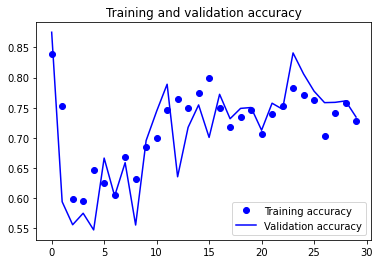

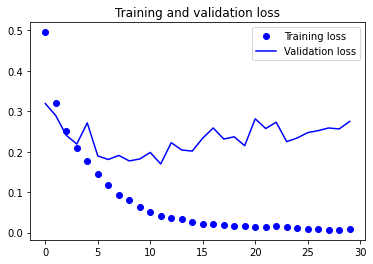

In [22]:
history = history1
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
embedding_dim = 256
model_2 = Sequential()
model_2.add(Embedding(input_vocab_size, embedding_dim,input_length = maxi))
model_2.add(LSTM(256, dropout=0.8, return_sequences=True))
model_2.add(LSTM(256, dropout=0.8))
model_2.add(Dense(num_categories, activation='sigmoid'))
model_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [27]:
#Early stopping point number of epochs is 24

#final training after hyparameter tuning

history2 = model_2.fit(totalX, totalY, validation_split=0, batch_size=512, epochs=24)
model_2.save_weights('./gdrive/MyDrive/Gowtham_Batchala_Interos_Challenge/checkpoints/checkpoint')

Epoch 1/24
42/42 [==============================] - 48s 1s/step - loss: 0.4196 - accuracy: 0.8355
Epoch 2/24
42/42 [==============================] - 44s 1s/step - loss: 0.2693 - accuracy: 0.6934
Epoch 3/24
42/42 [==============================] - 44s 1s/step - loss: 0.2309 - accuracy: 0.7267
Epoch 4/24
42/42 [==============================] - 44s 1s/step - loss: 0.1898 - accuracy: 0.7154
Epoch 5/24
42/42 [==============================] - 44s 1s/step - loss: 0.1230 - accuracy: 0.7543
Epoch 6/24
42/42 [==============================] - 44s 1s/step - loss: 0.0984 - accuracy: 0.7822
Epoch 7/24
42/42 [==============================] - 44s 1s/step - loss: 0.0872 - accuracy: 0.7706
Epoch 8/24
42/42 [==============================] - 44s 1s/step - loss: 0.0677 - accuracy: 0.7346
Epoch 9/24
42/42 [==============================] - 44s 1s/step - loss: 0.0577 - accuracy: 0.7141
Epoch 10/24
42/42 [==============================] - 43s 1s/step - loss: 0.0404 - accuracy: 0.7097
Epoch 11/24
42/42 [

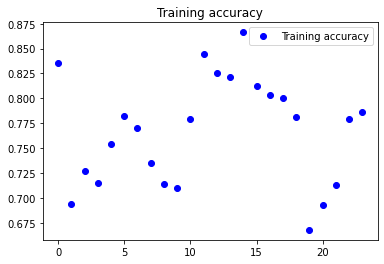

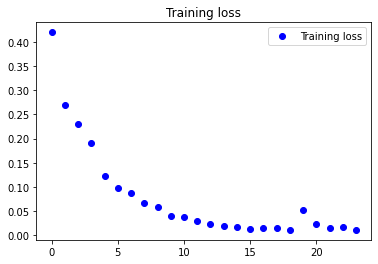

In [28]:
history = history2
import matplotlib.pyplot as plt

acc = history.history['accuracy']
#val_acc = history.history['val_accuracy']
loss = history.history['loss']
#val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
#plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
#plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training loss')
plt.legend()

plt.show()

# **Evaluation your model on private .sgm file**



*   Give the private test data path of the .sgm file
*   Mention number of .sgm files
*   If more than one .sgm files are there, then i would suggest using cell 8, which contains reading of the multiple .sgm files



In [77]:
private_test_data = '/content/gdrive/MyDrive/Gowtham_Batchala_Interos_Challenge/'
number_of_sgml_files = 1

sgml_file_name = 'reut2-021.sgm'



In [105]:
from numpy import zeros
# Those are the top 20 categories we will use for the classification
'''
selected_categories = ['pl_usa', 'to_earn', 'to_acq', 'pl_uk', 'pl_japan', 'pl_canada', 'to_money-fx',
 'to_crude', 'to_grain', 'pl_west-germany', 'to_trade', 'to_interest',
 'pl_france', 'or_ec', 'pl_brazil', 'to_wheat', 'to_ship', 'pl_australia',
 'to_corn', 'pl_china']
 '''
selected_categories = ['pl_usa', 'to_earn', 'to_acq', 'pl_uk'] 

# Parse SGML files
test_X = []
test_Y = []

def strip_tags(text):
    return re.sub('<[^<]+?>', '', text).strip()

def unescape(text):
    return saxutils.unescape(text)

# Iterate all files
file_name = sgml_file_name
print('Reading file: %s' % file_name)
with open(private_test_data + file_name, 'rb') as file:
    content = BeautifulSoup(file.read().lower(), "lxml")
            
    for newsline in content('reuters'):
        test_categories = []
                
        # News-line Id
        test_id = newsline['newid']
                
        # News-line text
        test_body = strip_tags(str(newsline('text')[0].text)).replace('reuter\n&#3;', '')
        test_body = unescape(test_body)
                
        # News-line categories
        topics = newsline.topics.contents
        places = newsline.places.contents
        people = newsline.people.contents
        orgs = newsline.orgs.contents
        exchanges = newsline.exchanges.contents
                
        for topic in topics:
            test_categories.append('to_' + strip_tags(str(topic)))
                    
        for place in places:
            test_categories.append('pl_' + strip_tags(str(place)))
                    
        for person in people:
            test_categories.append('pe_' + strip_tags(str(person)))
                    
        for org in orgs:
            test_categories.append('or_' + strip_tags(str(org)))
                    
        for exchange in exchanges:
            test_categories.append('ex_' + strip_tags(str(exchange)))
                
        # Create new document    
        update_frequencies(test_categories)
            
        test_X.append(test_body)
        test_Y.append(to_category_vector(test_categories, selected_categories))

Reading file: reut2-021.sgm


In [151]:
#nltk.download('punkt')
#nltk.download("wordnet")
testX = []
testY = np.array(test_Y)
for i, doc in enumerate(test_X):
    testX.append(cleanUpSentence(doc, stop_words))
    

In [141]:
len(test_X)

578

In [142]:
print((testX[100]))
print(testY[100])

african development bank plan u domestic bond frankfurt oct 19 african development bank plan toraise 200 mln dlrs via u domestic bond yearmilan kerno vice president finance said presentation said bank planned borrow 700 mln dlrs inworld capital market 1987 roughly amount in1988 weak condition euroyen marketplans bond sector would comprise part ofthe 700 mln dlrs put hold kerno said complete programme year marketswilling kerno said adding bank 1987 borrowing fartotaled 400 mln dlrs bank board director meet october 26 todiscuss plan begin bank trading unspecified securitieswith desk abidjan kerno said trading would conducted along similar line existingworld bank asian development bank operation said bank ha roughly 12 billion dlrs availableliquidity serve basis trading although ofthis traded start bank plan use thefunds gradually next three four year said facilitate lending increase bank tripled paidincapital 18 billion dlrs six billion june german banker presentation criticized bank for

In [124]:
len(test_Y)

578

In [128]:
max_vocab_size

200000

# **Word to Vector**

In [152]:
testX = np.array(pad_sequences(input_tokenizer.texts_to_sequences(testX), maxlen=maxi))



In [126]:
testX.shape

(578, 424)

In [120]:
testY.shape

(578, 4)

In [154]:
#model_1.save_weights('./gdrive/MyDrive/Interos_Challenge/checkpoints')

# Create a new model instance
embedding_dim = 256
model = Sequential()
model.add(Embedding(input_vocab_size, embedding_dim,input_length = maxi))
model.add(LSTM(256, dropout=0.8, return_sequences=True))
model.add(LSTM(256, dropout=0.8))
model.add(Dense(num_categories, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Restore the weights
model.load_weights('./gdrive/MyDrive/Gowtham_Batchala_Interos_Challenge/checkpoints/checkpoint')

# Evaluate the model
loss, acc = model.evaluate(testX, testY, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

19/19 - 3s - loss: 0.1529 - accuracy: 0.7145
Restored model, accuracy: 71.45%


# **Predicting your model on a single document**

In [172]:
doc110 = document_X[110]
print(doc110)
print(totalY[110])

u.s. m-1 money supply rose 2.1 billion dlrs
    new york, feb 26 - u.s. m-1 money supply rose 2.1 billion
dlrs to a seasonally adjusted 736.7 billion dlrs in the
february 16 week, the federal reserve said.
    the previous week's m-1 level was revised to 734.6 billion
dlrs from 734.2 billion dlrs, while the four-week moving
average of m-1 rose to 735.0 billion dlrs from 733.5 billion.
    economists polled by reuters said that m-1 should be
anywhere from down four billion dlrs to up 2.3 billion dlrs.
the average forecast called for a 300 mln dlr m-1 rise.
 reuter
[1. 0. 0. 0.]


In [156]:
input_x_110 = cleanUpSentence(doc110, stop_words)
print(input_x_110)

u m1 money supply rose 21 billion dlrs new york feb 26 u m1 money supply rose 21 billiondlrs seasonally adjusted 7367 billion dlrs thefebruary 16 week federal reserve said previous week m1 level wa revised 7346 billiondlrs 7342 billion dlrs fourweek movingaverage m1 rose 7350 billion dlrs 7335 billion economist polled reuters said m1 beanywhere four billion dlrs 23 billion dlrsthe average forecast called 300 mln dlr m1 rise reuter


In [171]:
text_Sample = np.array(pad_sequences(input_tokenizer.texts_to_sequences([input_x_110]), maxlen=maxLength))
predicted = model.predict(text_Sample)[0]
print(predicted.shape)


(4,)


In [169]:
for i, prob in enumerate(predicted):
    if prob > 0.5:
        print(selected_categories[i])

pl_usa


In [168]:
categories_220 = document_Y[110]
for i, prob in enumerate(categories_220):
    if prob > 0.5:
        print(selected_categories[i])

pl_usa


In [173]:
print(totalY[110])

[1. 0. 0. 0.]


The [1 0 0 0] implies 'pl_usa' category. Hence it is correclty classified.

# References 



*   [[https://github.com/giuseppebonaccorso/Reuters-21578-Classification/blob/master/Text%20Classification.ipynb](https://github.com/giuseppebonaccorso/Reuters-21578-Classification/blob/master/Text%20Classification.ipynb)]([https://github.com/giuseppebonaccorso/Reuters-21578-Classification/blob/master/Text%20Classification.ipynb](https://github.com/giuseppebonaccorso/Reuters-21578-Classification/blob/master/Text%20Classification.ipynb))
*   [https://stackoverflow.com/questions/5663980/importerror-no-module-named-beautifulsoup](https://stackoverflow.com/questions/5663980/importerror-no-module-named-beautifulsoup)
*[https://stackoverflow.com/questions/30667525/importerror-no-module-named-sklearn-cross-validation](https://stackoverflow.com/questions/30667525/importerror-no-module-named-sklearn-cross-validation)
*[https://stackoverflow.com/questions/60516579/dataframe-object-has-no-attribute-get-value-in-pandas](https://stackoverflow.com/questions/60516579/dataframe-object-has-no-attribute-get-value-in-pandas)
*[https://stackoverflow.com/questions/49837374/stackoverflow-error-when-using-setvalue](https://stackoverflow.com/questions/49837374/stackoverflow-error-when-using-setvalue)
*[https://stackoverflow.com/questions/7413326/python-error-message](https://stackoverflow.com/questions/7413326/python-error-message)
*[https://stackoverflow.com/questions/42339876/error-unicodedecodeerror-utf-8-codec-cant-decode-byte-0xff-in-position-0-in](https://stackoverflow.com/questions/42339876/error-unicodedecodeerror-utf-8-codec-cant-decode-byte-0xff-in-position-0-in)
*[https://www.programcreek.com/python/example/107282/nltk.stem.WordNetLemmatizer](https://www.programcreek.com/python/example/107282/nltk.stem.WordNetLemmatizer)

